## Training and validation curves

In [1]:
from psi.deep_wfs.utils.utils import get_metrics, plot_learningcurve
import numpy as np
import glob
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/gorban/python_scripts/')
from gox_tools import init_matplotlib
init_matplotlib('HowtoMakeAPlot')

In [19]:
wdir = '/mnt/disk12tb/METIS/PSI/models/'

m1 =  get_metrics(wdir + 'METIS_N2_CVC_mag=-2_bw=0.0_mask=one_spider_20%_Z20_s1e+04_nds')
m2 =  get_metrics(wdir + 'METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0')
m3 =  get_metrics(wdir + 'METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds')

plt.figure()
plt.plot(m1['train_loss'])
plt.plot(m2['train_loss'])
plt.plot(m3['train_loss'])

plt.plot(m1['val_loss'], c='C0', ls='--')
plt.plot(m2['val_loss'], c='C1', ls='--')
plt.plot(m3['val_loss'], c='C2', ls='--')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()
# plot_learningcurve(m1, save=False)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk12tb/METIS/PSI/models/METIS_N2_CVC_mag=-2_bw=0.0_mask=one_spider_20%_Z20_s1e+04_nds/metrics.json'

## Generating test datasets

In [2]:
from psi.deepSensor import DeepSensor
import json

def generate_test_dataset(tag_name, nb_samples=None):
    wdir = '/mnt/disk12tb/METIS/PSI/WV_screens/'
    fname_ps_test = 'cube_285_1e4_L0=500m_noTT_200nm.fits'
    config_file = '/home/gorban/github/PSI/config/config_deep_learning.py'

    # Reading the parameters of the dataset used for the 'tag_name' model
    mdir = '/mnt/disk12tb/METIS/PSI/models/'
    f_params = mdir + tag_name + '/data_info.json'

    with open(f_params) as f:
        _config = json.load(f)

    deep = DeepSensor(config_file)

    print('Changing configuration')
    for k in _config.keys():
        if hasattr(deep.cfg.params, k):
            setattr(deep.cfg.params, k, _config[k])
        else:
            print('Warning, psi cfg has not attr {0}'.format(k))

    # check
    print(deep.cfg.params.save_dirname)

    deep.cfg.check_parameters()
    deep.cfg.compute_parameters()
    deep.cfg.params.save_loop_statistics = False
    # Setup Kernel
    deep.setup()

    deep.generator.setup(deep.inst, deep.C2M, deep.cfg.params)
    if nb_samples is not None:
        deep.logger.info('Setting the number of samples to {0}'.format(nb_samples))
        deep.generator.config['nb_samples'] = nb_samples

    deep.generator.genData('test_{0:.0e}_'.format(deep.generator.config['nb_samples']) +\
                            tag_name, store_data=True,
                            phase_fname=wdir+fname_ps_test)


In [4]:
tag0='METIS_N2_IMG_mag=0_bw=0.0_mask=two_spiders_Z20_s1e+04_nds_v1_t2'
tag1='METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0'
tag2='METIS_N2_CVC_mag=-2_bw=0.0_mask=one_spider_20%_Z20_s1e+04_nds'
tag3='METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'

# generate_test_dataset(tag0, nb_samples=1000)
# print('## CVC 1')
# generate_test_dataset(tag1, nb_samples=1000)
# print('## CVC 2')
# generate_test_dataset(tag2, nb_samples=1000)
# print('## CVC 3')
# generate_test_dataset(tag3, nb_samples=1000)

# tag4='METIS_N2_CVC_mag=-4_bw=0.0_mask=two_spiders_15%_Z20_s1e+04_nds'
# print('## CVC 2 spiders')
# generate_test_dataset(tag4, nb_samples=1000)

tag5='METIS_N2_CVC_mag=-4_bw=0.0_mask=one_spider_15%_Z20_s1e+04_nds'
print('## CVC 2 spiders')
generate_test_dataset(tag5, nb_samples=1000)


## CVC 2 spiders
DEEP - [Info]:  Loading and checking configuration
Params - [Info]:  Detector resolution is 9.33 px/(lbda/D)
Changing configuration
Warning, psi cfg has not attr 0
Warning, psi cfg has not attr channels
Warning, psi cfg has not attr config_simulation
Warning, psi cfg has not attr dataset_path
Warning, psi cfg has not attr defocus
Warning, psi cfg has not attr nb_samples
Warning, psi cfg has not attr noisy
Warning, psi cfg has not attr phasescreen_fname
Warning, psi cfg has not attr zernike_unit
Warning, psi cfg has not attr training_data_fname
METIS_N2_CVC_mag=-4_bw=0_WV=True_Z=20_fr=10Hz_asym=15%_mask=one_spider_2024-05-29T15:53:23
DEEP - [Info]:  Initialize the instrument object & building the optical model
CompassInstrument - [Info]:  Asymmetric stop frac. surface 6.0 [%]
CompassInstrument - [Warning]:  Customizing entrance aperture as a function of NCPA map definition
CompassInstrument - [Info]:  Building a Classical Vortex Coronagraph optical model in HCIPy
DEEP -

100%|██████████| 1000/1000 [19:54<00:00,  1.19s/it]


## Evaluation test datasets

To do:
- generic function 
- automatic tes datasest sselection ?
- automatic (re-configuration) -- see above
- illustration : PSFs dataset, after noise ; reconstructed phase ...


* Test modell in 'real conditions'  <--> using simulator, no delay and comparing to mode projection


In [7]:
from psi.configParser import loadConfiguration
from psi.instruments import CompassSimInstrument, HcipySimInstrument
import psi.psi_utils as psi_utils
from psi.deepSensor import DeepSensor

import hcipy
from astropy.visualization import imshow_norm, LogStretch, SqrtStretch,\
    MinMaxInterval
import matplotlib.pyplot as plt
import numpy as np
import psi.deep_wfs.utils.read_data as rt
import astropy.io.fits as fits
import glob, os
from psi.deep_wfs.utils.dataset_format_pytorch import normalization
import json


In [8]:

# model_tag = 'METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_r1'
# f_dataset = 'ds_METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_r1.h5'

# list_test_datasets=[
# "ds_test_1e+03_METIS_N2_IMG_mag=0_bw=0.0_mask=two_spiders_Z20_s1e+04_nds_v1_t2.h5",
# "ds_test_1e+03_METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0.h5", 
# "ds_test_1e+03_METIS_N2_CVC_mag=-2_bw=0.0_mask=one_spider_20%_Z20_s1e+04_nds.h5", 
# "ds_test_1e+03_METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds.h5"
# ]

# model_tag = 'METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'

def evaluate_test(model_tag, f_dataset, mag=0, ntests=100, bw=None):
    ds_datadir = '/mnt/disk12tb/METIS/PSI/datasets/'    
    dir_model = '/mnt/disk12tb/METIS/PSI/models/'
    model_path = dir_model + model_tag + '/'
    config_file='config/config_deep_learning.py'
    ncpa_folder='/mnt/disk12tb/METIS/PSI/legacy/TestArea/NCPA_Tibor/'
    turb_folder='/mnt/disk12tb/METIS/PSI/legacy/TestArea/COMPASSPhaseScreens/ThirdAttempt_Processed/'
    wv_folder='/mnt/disk12tb/METIS/PSI/legacy/TestArea/WaterVapour/phases/'

    save_basedir='/home/gorban/'

    # Reading the parameters of the dataset used for the 'tag_name' model
    f_params = model_path + '/data_info.json'
    with open(f_params) as f:
        _config = json.load(f)

    deep_sensor = DeepSensor(config_file)

    print('Changing configuration')
    for k in _config.keys():
        if hasattr(deep_sensor.cfg.params, k):
            setattr(deep_sensor.cfg.params, k, _config[k])
        else:
            print('Warning, psi cfg has not attr {0}'.format(k))
    
    deep_sensor.cfg.params.mag = mag
    if bw is not None:
        deep_sensor.cfg.params.bandwidth=bw

    print('[debug] mag={0}'.format(deep_sensor.cfg.params.mag))
    deep_sensor.cfg.params.ncpa_folder = ncpa_folder
    deep_sensor.cfg.params.turb_folder = turb_folder
    deep_sensor.cfg.params.wv_folder = wv_folder
    deep_sensor.cfg.params.save_basedir = save_basedir
    deep_sensor.cfg.params.save_loop_statistics=False

    deep_sensor.cfg.check_parameters()
    deep_sensor.cfg.compute_parameters()

    deep_sensor.setup()
    deep_sensor.init_evaluator(model_fname=model_path)
    evaluator = deep_sensor.evaluator


    db, attrs = rt.read_h5(ds_datadir + f_dataset)
    psfs = db['psfs_1']
    
    nzern=20
    n_tests=ntests
    modes_truth = np.zeros((n_tests, nzern))
    modes_meas = np.zeros((n_tests, nzern))
    noise = 2
    num_photons = deep_sensor.getFluxInFocalPlane() #/ 10000 #self.inst.num_photons
    bckg_level = deep_sensor.inst.bckg_level

    # --- Check PSF normalization --
    # _data_info = evaluator.data_info
    # dataset_normalized = normalization(db,
    #                                    _data_info,                                         
    #                                     noise=noise,
    #                                     signal=num_photons,
    #                                     bckg=bckg_level)
    # print("# of photons {0}".format(num_photons))
    # print("# of bckg photons {0}".format(bckg_level))


    for i in range(n_tests):
        modes_truth[i] = db['zernike_coefficients'][i]
        modes_meas[i] = evaluator.infer(psfs[i][np.newaxis, :, :],
                                        noise=noise,
                                        signal=num_photons,
                                        bckg=bckg_level).squeeze()

    err = np.sqrt(np.mean((modes_meas - modes_truth)**2, axis=0))
    std_truth = np.std(modes_truth, axis=0)

    # plt.figure()
    # plt.plot(err, label='res. error')
    # plt.plot(std_truth, label='input')
    # plt.legend()
    # plt.semilogy()
    print('Total error {0:.1f}nm'.format(np.sqrt(np.sum(err**2))))

    return err, std_truth
    # return dataset_normalized

In [ ]:
import json

model_tag = 'METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0'

mdir = '/mnt/disk12tb/METIS/PSI/models/'
f_params = mdir + model_tag + '/data_info.json'

with open(f_params) as f:
    _config = json.load(f)

_config

DEEP - [Info]:  Loading and checking configuration
Params - [Info]:  Detector resolution is 9.33 px/(lbda/D)
DEEP - [Info]:  Initialize the instrument object & building the optical model
CompassInstrument - [Info]:  Asymmetric stop frac. surface 5.8 [%]
CompassInstrument - [Warning]:  Customizing entrance aperture as a function of NCPA map definition
CompassInstrument - [Info]:  Building a Classical Vortex Coronagraph optical model in HCIPy
DEEP - [Info]:  Initializing modal basis with 20 modes
DEEP - [Info]:  Preparing for inference
DEEP - [Info]:  All configuration checks done.
# of photons 663163588.0946298
# of bckg photons 10570444.79727745
deep_infer - [Info]:  Loading CNN model for the 1st time
Total error 42.1nm


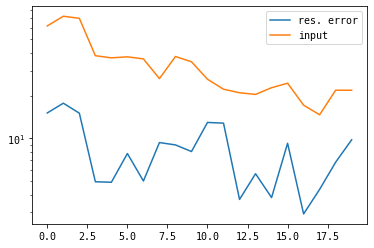

In [50]:
list_test_datasets=[
"ds_test_1e+03_METIS_N2_IMG_mag=0_bw=0.0_mask=two_spiders_Z20_s1e+04_nds_v1_t2.h5",
"ds_test_1e+03_METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0.h5", 
"ds_test_1e+03_METIS_N2_CVC_mag=-2_bw=0.0_mask=one_spider_20%_Z20_s1e+04_nds.h5", 
"ds_test_1e+03_METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds.h5"
]

f_dataset=list_test_datasets[1]
model_tag = 'METIS_N2_CVC_mag=-2_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds_v1_t0'
# model_tag = 'METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'

ds = evaluate_test(model_tag, f_dataset)

(<matplotlib.image.AxesImage at 0x7f1628ea4190>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f1628d87850>)

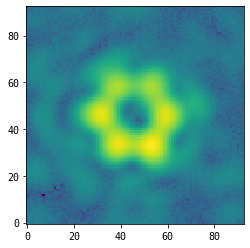

In [51]:
pp = np.array(ds[10]['image'])[0]
# np.array(pp['image']).shape
plt.figure()
imshow_norm(pp, stretch=SqrtStretch())

## Sensor noise -- 2 lyot mask 20%

In [5]:
mag = [-4, -2, 0, 2, 3]
nt = 100
bw=0

models = ['METIS_N2_CVC_mag={0}_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'.format(mag[0]),
          'METIS_N2_CVC_mag={0}_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'.format(mag[1]),
          'METIS_N2_CVC_mag={0}_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'.format(mag[2]),
          'METIS_N2_CVC_mag={0}_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'.format(mag[3]),
          'METIS_N2_CVC_mag={0}_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'.format(mag[4])]

f_dataset = 'ds_test_1e+03_METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds.h5'

err_0, truth = evaluate_test(models[0], f_dataset, mag=mag[0], ntests=nt, bw=bw)
err_1, truth = evaluate_test(models[1], f_dataset, mag=mag[1], ntests=nt, bw=bw)
err_2, truth = evaluate_test(models[2], f_dataset, mag=mag[2], ntests=nt, bw=bw)
err_3, truth = evaluate_test(models[3], f_dataset, mag=mag[3], ntests=nt, bw=bw)
err_4, truth = evaluate_test(models[4], f_dataset, mag=mag[4], ntests=nt, bw=bw)

rms_wfe = np.zeros(len(mag))
rms_wfe[0] = np.sqrt(np.sum(err_0**2))
rms_wfe[1] = np.sqrt(np.sum(err_1**2))
rms_wfe[2] = np.sqrt(np.sum(err_2**2))
rms_wfe[3] = np.sqrt(np.sum(err_3**2))
rms_wfe[4] = np.sqrt(np.sum(err_4**2))

# for i in range(len(mag)):



DEEP - [Info]:  Loading and checking configuration
Params - [Info]:  Detector resolution is 9.33 px/(lbda/D)
Changing configuration
Warning, psi cfg has not attr 0
Warning, psi cfg has not attr channels
Warning, psi cfg has not attr config_simulation
Warning, psi cfg has not attr dataset_path
Warning, psi cfg has not attr defocus
Warning, psi cfg has not attr nb_samples
Warning, psi cfg has not attr noisy
Warning, psi cfg has not attr phasescreen_fname
Warning, psi cfg has not attr zernike_unit
[debug] mag=-4
DEEP - [Info]:  Initialize the instrument object & building the optical model
CompassInstrument - [Info]:  Asymmetric stop frac. surface 5.8 [%]
CompassInstrument - [Warning]:  Customizing entrance aperture as a function of NCPA map definition
CompassInstrument - [Info]:  Building a Classical Vortex Coronagraph optical model in HCIPy
DEEP - [Info]:  Initializing modal basis with 20 modes
DEEP - [Info]:  Preparing for inference
DEEP - [Warning]:  mag not the same [0, -4]
DEEP - [In

In [14]:
# model_15 = 'METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_15%_Z20_s1e+04_nds'
# err_15, truth = evaluate_test(model_15, f_dataset, mag=0, ntests=nt, bw=bw)
# rms_wfe_15 = np.sqrt(np.sum(err_15**2))

f_dataset_2sp = "ds_test_1e+03_METIS_N2_CVC_mag=-4_bw=0.0_mask=two_spiders_15%_Z20_s1e+04_nds.h5"
model_15_2sp = 'METIS_N2_CVC_mag=-4_bw=0.0_mask=two_spiders_15%_Z20_s1e+04_nds'
err_15_2sp, truth = evaluate_test(model_15_2sp, f_dataset_2sp, mag=-4, ntests=nt, bw=bw)
rms_wfe_15_2sp = np.sqrt(np.sum(err_15_2sp**2))

DEEP - [Info]:  Loading and checking configuration


Params - [Info]:  Detector resolution is 9.33 px/(lbda/D)
Changing configuration
Warning, psi cfg has not attr 0
Warning, psi cfg has not attr channels
Warning, psi cfg has not attr config_simulation
Warning, psi cfg has not attr dataset_path
Warning, psi cfg has not attr defocus
Warning, psi cfg has not attr nb_samples
Warning, psi cfg has not attr noisy
Warning, psi cfg has not attr phasescreen_fname
Warning, psi cfg has not attr zernike_unit
Warning, psi cfg has not attr training_data_fname
[debug] mag=-4
DEEP - [Info]:  Initialize the instrument object & building the optical model
CompassInstrument - [Info]:  Asymmetric stop frac. surface 6.5 [%]
CompassInstrument - [Warning]:  Customizing entrance aperture as a function of NCPA map definition
CompassInstrument - [Info]:  Building a Classical Vortex Coronagraph optical model in HCIPy
DEEP - [Info]:  Initializing modal basis with 20 modes
DEEP - [Info]:  Preparing for inference
DEEP - [Info]:  All configuration checks done.
deep_in

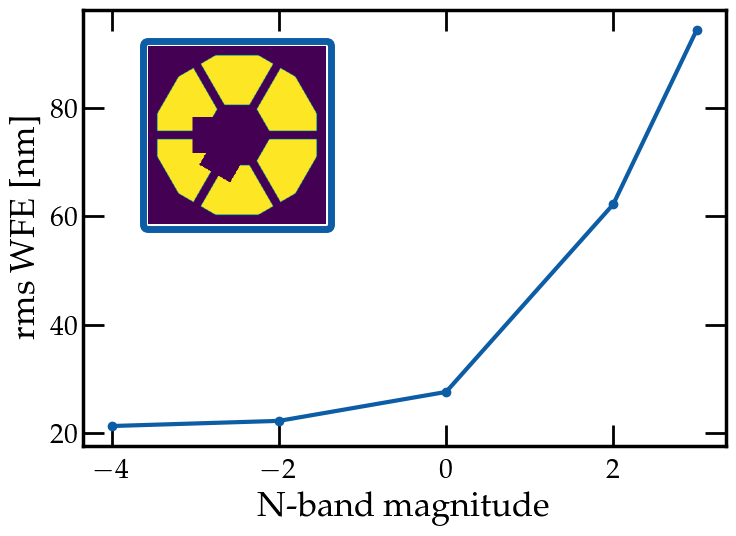

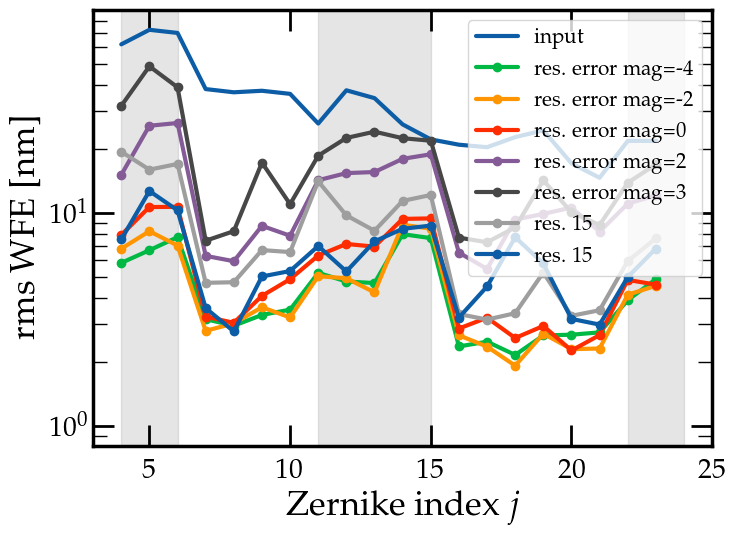

In [15]:
savedir = '/home/gorban/python_scripts/psi/plots/'
plt.figure(figsize=(8,6))
plt.plot(mag, rms_wfe, 'o-')
plt.xlabel('N-band magnitude')
plt.ylabel('rms WFE [nm]')
# plt.title(r'N2 CVC; 20\% two_lyot; 0\% bandwidth')

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

path = '/home/gorban/python_scripts/psi/'
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom, origin='upper')
ab = AnnotationBbox(getImage(path+ 'asym_two_lyot_20%.png', zoom=0.5),
                    (-2.5, 75), frameon=True, 
                    bboxprops =dict(boxstyle="round,pad=0.25",
                                    edgecolor='C0', lw = 5, width=2, height=2))
plt.gca().add_artist(ab)

plt.tight_layout()
# plt.savefig(savedir + '20240528_deep_CVC_perf_10Hz_20Z_sensor_noise_2lyot.pdf')

mode_index = np.arange(4, len(truth)+4)
plt.figure(figsize=(8,6))
plt.plot(mode_index, truth, label='input')
plt.plot(mode_index, err_0, 'o-', label='res. error mag={0}'.format(mag[0]))
plt.plot(mode_index, err_1, 'o-', label='res. error mag={0}'.format(mag[1]))
plt.plot(mode_index, err_2, 'o-', label='res. error mag={0}'.format(mag[2]))
plt.plot(mode_index, err_3, 'o-', label='res. error mag={0}'.format(mag[3]))
plt.plot(mode_index, err_4, 'o-', label='res. error mag={0}'.format(mag[4]))
plt.plot(mode_index, err_15, 'o-', label='res. 15%')
plt.plot(mode_index, err_15_2sp, 'o-', label='res. 15%')


plt.fill_between([4, 6], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.fill_between([11, 15], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.fill_between([22, len(truth)+4], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.semilogy()
plt.xlabel('Zernike index $j$')
plt.ylabel('rms WFE [nm]')
# plt.title('N2 CVC; 20\% two_lyot; 0\% bandwidth')
plt.tight_layout()
# plt.savefig(savedir + '20240528_deep_CVC_modal_10Hz_20Z_sensor_noise_2lyot.pdf')


## Comparing masks 

In [9]:
nt = 100
bw=0

model = 'METIS_N2_CVC_mag=-4_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds'
f_dataset = 'ds_test_1e+03_METIS_N2_CVC_mag=0_bw=0.0_mask=two_lyot_20%_Z20_s1e+04_nds.h5'
err_0, truth = evaluate_test(model, f_dataset, mag=-4, ntests=nt, bw=bw)
rms_wfe_20_2l = np.sqrt(np.sum(err_0**2))


f_dataset_2sp = "ds_test_1e+03_METIS_N2_CVC_mag=-4_bw=0.0_mask=two_spiders_15%_Z20_s1e+04_nds.h5"
model_15_2sp = 'METIS_N2_CVC_mag=-4_bw=0.0_mask=two_spiders_15%_Z20_s1e+04_nds'
err_15_2sp, truth = evaluate_test(model_15_2sp, f_dataset_2sp, mag=-4, ntests=nt, bw=bw)
rms_wfe_15_2sp = np.sqrt(np.sum(err_15_2sp**2))


f_dataset_1sp = "ds_test_1e+03_METIS_N2_CVC_mag=-4_bw=0.0_mask=one_spider_15%_Z20_s1e+04_nds.h5"
model_15_1sp = 'METIS_N2_CVC_mag=-4_bw=0.0_mask=one_spider_15%_Z20_s1e+04_nds'
err_15_1sp, truth = evaluate_test(model_15_1sp, f_dataset_1sp, mag=-4, ntests=nt, bw=bw)
rms_wfe_15_1sp = np.sqrt(np.sum(err_15_2sp**2))

DEEP - [Info]:  Loading and checking configuration
Params - [Info]:  Detector resolution is 9.33 px/(lbda/D)
Changing configuration
Warning, psi cfg has not attr 0
Warning, psi cfg has not attr channels
Warning, psi cfg has not attr config_simulation
Warning, psi cfg has not attr dataset_path
Warning, psi cfg has not attr defocus
Warning, psi cfg has not attr nb_samples
Warning, psi cfg has not attr noisy
Warning, psi cfg has not attr phasescreen_fname
Warning, psi cfg has not attr zernike_unit
[debug] mag=-4
DEEP - [Info]:  Initialize the instrument object & building the optical model
CompassInstrument - [Info]:  Asymmetric stop frac. surface 5.8 [%]
CompassInstrument - [Warning]:  Customizing entrance aperture as a function of NCPA map definition
CompassInstrument - [Info]:  Building a Classical Vortex Coronagraph optical model in HCIPy
DEEP - [Info]:  Initializing modal basis with 20 modes
DEEP - [Info]:  Preparing for inference
DEEP - [Warning]:  mag not the same [0, -4]
DEEP - [In

In [20]:
# %matplotlib widget
mode_index = np.arange(4, len(truth)+4)
plt.figure(figsize=(8,6))
plt.plot(mode_index, truth, label='input')
plt.plot(mode_index, err_0, 'o-', label='two lyot 20\% (T=94.2\%)')
plt.plot(mode_index, err_15_2sp, 'o-', label='two spiders 15\% (T=93.5\%)')
plt.plot(mode_index, err_15_1sp, 'o-', label='one spider 15\% (T=94\%)')


plt.fill_between([4, 6], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.fill_between([11, 15], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.fill_between([22, len(truth)+4], 0, 1,
                color='grey', alpha=0.2,
                transform=plt.gca().get_xaxis_transform())
plt.legend()
plt.semilogy()
plt.xlabel('Zernike index $j$')
plt.ylabel('rms WFE [nm]')
# plt.title('N2 CVC; 20\% two_lyot; 0\% bandwidth')
plt.tight_layout()
savedir = '/home/gorban/python_scripts/psi/plots/'
plt.savefig(savedir + '20240530_CVC_mask_comparison.pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
%matplotlib widget

plt.figure()
plt.plot(np.arange(10), label='toto')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …